# Network analysis in Python

Finding a shortest path using a specific street network is a common GIS problem that has many practical
applications. For example navigators are one of those "every-day" applications where **routing** using specific algorithms is used to find the optimal route between two (or multiple) points.

It is also possible to perform network analysis such as tranposrtation routing in Python.
[Networkx](https://networkx.github.io/documentation/stable/) is a Python module that provides tools for analyzing networks in various different ways. It also contains algorithms
such as [Dijkstra's algorithm](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.shortest_paths.weighted.single_source_dijkstra.html#networkx.algorithms.shortest_paths.weighted.single_source_dijkstra) or
[A*](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.shortest_paths.astar.astar_path.html#networkx.algorithms.shortest_paths.astar.astar_path) algoritm that are commonly used to find shortest paths along transportation network.

To be able to conduct network analysis, it is, of course, necessary to have a network that is used for the analyses. The [OSMnx](https://github.com/gboeing/osmnx) package enables us to retrieve routable networks from OpenStreetMap for various transport modes (walking, cycling and driving). OSMnx also combines some functionalities from `networkx` module to make it straightforward to conduct routing analysis based on OpenStreetMap data.

Next we will test the routing functionalities of OSMnx by finding a shortest path between two points based on drivable roads. With tiny modifications, it is also possible to repeat the analysis for the walkable street network.

## Get the network

Let's again start by importing the required modules

In [1]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from pyproj import CRS

When fetching netowrk data from OpenStreetMap using OSMnx, it is possible to define the type of street network using the `network_type` parameter (see options from the [OSMnx documentation](https://osmnx.readthedocs.io/en/stable/osmnx.html?highlight=graph%20from%20place#osmnx.graph.graph_from_place)).
Let's download the OSM data from Kamppi but this only the bike network. If that does not work, try the driveable network (less roads, faster query..).

In [2]:
place_name = "Kamppi, Helsinki, Finland"

# Retrieve the network
graph = ox.graph_from_place(place_name, network_type='bike')

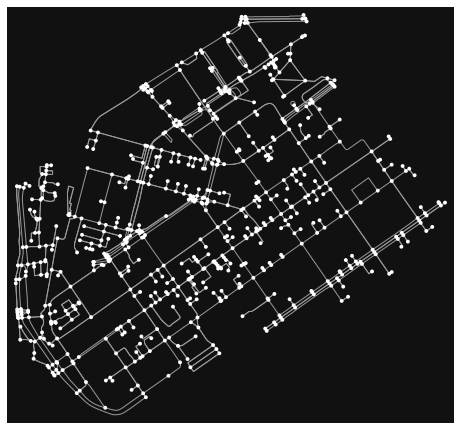

In [3]:
# plot the graph:
fig, ax = ox.plot_graph(graph)

Pro tip! Sometimes the shortest path might go slightly outside the defined area of interest. To account for this, we can fetch the network for a bit larger area than the district of Kamppi, in case the shortest path is not completely inside its boundaries. 

In [4]:
# Get the area of interest polygon
place_polygon = ox.geocode_to_gdf(place_name)

# Re-project the polygon to a local projected CRS 
place_polygon = place_polygon.to_crs(epsg=3067)

# Buffer a bit
place_polygon["geometry"] = place_polygon.buffer(200)

# Re-project the polygon back to WGS84, as required by osmnx
place_polygon = place_polygon.to_crs(epsg=4326)

# Retrieve the network
graph = ox.graph_from_polygon(place_polygon["geometry"].values[0], network_type='bike')

Plot the graph:

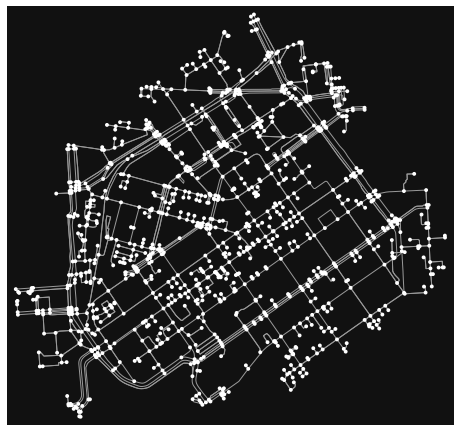

In [5]:
fig, ax = ox.plot_graph(graph)

Okey so now we have streets for the travel mode we specified earlier. Let's have a colser look at the attributes of the street network. Easiest way to do this is to convert the
graph (nodes and edges) into GeoDataFrames.

Converting graph into a GeoDataFrame can be done with function `graph_to_gdfs()` that we already used in previous tutorial. With parameters `nodes` and `edges`, it is possible to control whether to retrieve both nodes and edges from the graph. 

In [6]:
# Retrieve only edges from the graph
edges = ox.graph_to_gdfs(graph, nodes=False, edges=True)

In [7]:
# Check columns
edges.columns

Index(['osmid', 'oneway', 'lanes', 'name', 'highway', 'maxspeed', 'length',
       'geometry', 'access', 'bridge', 'junction', 'tunnel', 'service', 'u',
       'v', 'key'],
      dtype='object')

In [8]:
# Check crs
edges.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Note that the CRS of the GeoDataFrame is be WGS84 (epsg: 4326).

In [9]:
edges.head()

,osmid,oneway,lanes,name,highway,maxspeed,length,geometry,access,bridge,junction,tunnel,service,u,v,key
0,23717777,True,2,Porkkalankatu,primary,40,10.404,"LINESTRING (24.92106 60.16479, 24.92087 60.16479)",NaN,NaN,NaN,NaN,NaN,25216594,1372425721,0
1,23856784,True,2,Mechelininkatu,primary,40,40.885,"LINESTRING (24.92106 60.16479, 24.92095 60.164...",NaN,NaN,NaN,NaN,NaN,25216594,1372425714,0
2,"[59355210, 4229487]",False,2,Santakatu,residential,30,44.310,"LINESTRING (24.91994 60.16279, 24.91932 60.162...",NaN,NaN,NaN,NaN,NaN,25238865,146447626,0
3,7842621,False,NaN,Sinikaislankuja,residential,30,76.704,"LINESTRING (24.91994 60.16279, 24.91995 60.162...",NaN,NaN,NaN,NaN,NaN,25238865,57661989,0
4,231643806,False,NaN,NaN,cycleway,NaN,59.812,"LINESTRING (24.91994 60.16279, 24.92014 60.162...",NaN,NaN,NaN,NaN,NaN,25238865,314767800,0


Okey, so we have quite many columns in our GeoDataFrame. Most of the columns are fairly self-explanatory but the following table describes all of them.
Most of the attributes come directly from the OpenStreetMap, however, columns `u` and `v` are Networkx specific ids. You can click on the links to get more information about each attribute:


| Column                                                     | Description                 | Data type         |
|------------------------------------------------------------|-----------------------------|-------------------|
| [bridge](http://wiki.openstreetmap.org/wiki/Key:bridge)    | Bridge feature              | boolean           |
| geometry                                                   | Geometry of the feature     | Shapely.geometry  |
| [highway](http://wiki.openstreetmap.org/wiki/Key:highway)  | Tag for roads (road type)   | str / list        |
| [lanes](http://wiki.openstreetmap.org/wiki/Key:lanes)      | Number of lanes             | int (or nan)      |
| [lenght](http://wiki.openstreetmap.org/wiki/Key:length)    | Length of feature (meters)  | float             |
| [maxspeed](http://wiki.openstreetmap.org/wiki/Key:maxspeed)| maximum legal speed limit   | int /list         |
| [name](http://wiki.openstreetmap.org/wiki/Key:name)        | Name of the (street) element| str (or nan)      |
| [oneway](http://wiki.openstreetmap.org/wiki/Key:oneway)    | One way road                | boolean           |
| [osmid](http://wiki.openstreetmap.org/wiki/Node)           | Unique ids for the element  | list              |
| [u](http://ow.ly/bV8n30h7Ufm)                              | The first node of edge      | int               |
| [v](http://ow.ly/bV8n30h7Ufm)                              | The last node of edge       | int               |


Let's take a look what kind of features we have in the `highway` column:

In [10]:
edges['highway'].value_counts()

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 1709, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


service                      873
cycleway                     484
residential                  466
tertiary                     217
primary                      164
pedestrian                   134
secondary                    121
unclassified                  42
living_street                 16
[residential, cycleway]        6
[living_street, service]       6
[pedestrian, residential]      4
[pedestrian, cycleway]         2
[service, pedestrian]          2
tertiary_link                  2
[unclassified, service]        1
primary_link                   1
Name: highway, dtype: int64

I now we can confirm that as a result our street network indeed only contains such streets where it is allowed to drive with a car as there are no e.g. cycleways or footways included in the data.

As the data is in WGS84 format, we might want to reproject our data into a metric system before proceeding to the shortest path analysis.
We can re-project the graph from latitudes and longitudes to an appropriate UTM zone using the [project_graph()](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.projection.project_graph) function from OSMnx. 

In [11]:
# Project the data
graph_proj = ox.project_graph(graph) 

In [12]:
# Get Edges and Nodes
nodes_proj, edges_proj = ox.graph_to_gdfs(graph_proj, nodes=True, edges=True)

In [13]:
print("Coordinate system:", edges_proj.crs)

Coordinate system: +proj=utm +zone=35 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs


In [14]:
edges_proj.head()

,osmid,oneway,lanes,name,highway,maxspeed,length,geometry,access,bridge,junction,tunnel,service,u,v,key
0,23717777,True,2,Porkkalankatu,primary,40,10.404,"LINESTRING (384631.322 6671580.071, 384620.884...",NaN,NaN,NaN,NaN,NaN,25216594,1372425721,0
1,23856784,True,2,Mechelininkatu,primary,40,40.885,"LINESTRING (384631.322 6671580.071, 384624.750...",NaN,NaN,NaN,NaN,NaN,25216594,1372425714,0
2,"[59355210, 4229487]",False,2,Santakatu,residential,30,44.310,"LINESTRING (384562.162 6671358.993, 384527.710...",NaN,NaN,NaN,NaN,NaN,25238865,146447626,0
3,7842621,False,NaN,Sinikaislankuja,residential,30,76.704,"LINESTRING (384562.162 6671358.993, 384562.951...",NaN,NaN,NaN,NaN,NaN,25238865,57661989,0
4,231643806,False,NaN,NaN,cycleway,NaN,59.812,"LINESTRING (384562.162 6671358.993, 384573.361...",NaN,NaN,NaN,NaN,NaN,25238865,314767800,0


Okey, as we can see from the CRS the data is now in [UTM projection](https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system) using zone 35 which is the one used for Finland, and indeed the orientation of the map and the geometry values also confirm this.


Furthermore, we can check the epsg code of this projection using pyproj CRS:

In [15]:
CRS(edges_proj.crs).to_epsg()

32635

Indeed, the projection is now [WGS 84 / UTM zone 35N, EPSG:32635](https://epsg.io/32635).

## Analyzing the network properties

Now as we have seen some of the basic functionalities of OSMnx such as downloading the data and converting data from graph to GeoDataFrame, we can take a look some of the analytical features of omsnx. Osmnx includes many useful functionalities to extract information about the network.

To calculate some of the basic street network measures we can use [basic_stats()](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.stats.basic_stats) function in OSMnx:

In [16]:
# Calculate network statistics
stats = ox.basic_stats(graph_proj, circuity_dist='euclidean')
stats

{'n': 1182,
 'm': 2541,
 'k_avg': 4.299492385786802,
 'intersection_count': 865,
 'streets_per_node_avg': 2.6996615905245345,
 'streets_per_node_counts': {0: 0, 1: 317, 2: 16, 3: 572, 4: 259, 5: 18},
 'streets_per_node_proportion': {0: 0.0,
  1: 0.26818950930626057,
  2: 0.01353637901861252,
  3: 0.48392554991539766,
  4: 0.21912013536379019,
  5: 0.015228426395939087},
 'edge_length_total': 90784.85899999987,
 'edge_length_avg': 35.72800432900428,
 'street_length_total': 56745.758000000016,
 'street_length_avg': 36.49244887459808,
 'street_segments_count': 1555,
 'node_density_km': None,
 'intersection_density_km': None,
 'edge_density_km': None,
 'street_density_km': None,
 'circuity_avg': 1.0452946617747503,
 'self_loop_proportion': 0.0015741833923652105,
 'clean_intersection_count': None,
 'clean_intersection_density_km': None}

To be able to extract the more advanced statistics (and some of the missing ones above) from the street network, it is required to have information about the coverage area of the network. Let's calculate the area of the [convex hull](https://en.wikipedia.org/wiki/Convex_hull) of the street network and see what we can get.



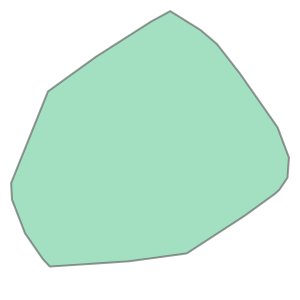

In [17]:
# Get the Convex Hull of the network
convex_hull = edges_proj.unary_union.convex_hull

# Show output
convex_hull

Now we can use the Convex Hull above to calculate [extended statistics for the network](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.stats.extended_stats). As some of the metrics are produced separately for each node, they produce a lot of output. Here, we combine the basic and extended statistics into one pandas Series to keep things in more compact form.

In [18]:
# Calculate the area
area = convex_hull.area

# Calculate statistics with density information
stats = ox.basic_stats(graph_proj, area=area)
extended_stats = ox.extended_stats(graph_proj, ecc=True, cc=True)

# Add extened statistics to the basic statistics
for key, value in extended_stats.items():
    stats[key] = value
    
# Convert the dictionary to a Pandas series for a nicer output
pd.Series(stats)

n                                                                                   1182
m                                                                                   2541
k_avg                                                                            4.29949
intersection_count                                                                   865
streets_per_node_avg                                                             2.69966
streets_per_node_counts                     {0: 0, 1: 317, 2: 16, 3: 572, 4: 259, 5: 18}
streets_per_node_proportion            {0: 0.0, 1: 0.26818950930626057, 2: 0.01353637...
edge_length_total                                                                90784.9
edge_length_avg                                                                   35.728
street_length_total                                                              56745.8
street_length_avg                                                                36.4924
street_segments_count

As we can see, now we have a **LOT** of information about our street network that can be used to understand its structure. We can for example see that the average node density in our network is `149 nodes/km` and that the total edge length of our network is almost 20 kilometers.

Furthermore, we can see that the [degree centrality](https://en.wikipedia.org/wiki/Centrality) of our network is on average `0.0326515`. Degree is a simple centrality measure that counts how many neighbors a node has (here a fraction of nodes it is connected to). Another interesting measure is the [PageRank](https://en.wikipedia.org/wiki/PageRank) that measures the importance of specific node in the graph. Here we can see that the most important node in our graph seem to a node with osmid `25416262`. PageRank was the algorithm that Google first developed (Larry Page & Sergei Brin) to order the search engine results and became famous for.

You can read the [Wikipedia article about different centrality measures](https://en.wikipedia.org/wiki/Centrality) if you are interested what the other centrality measures mean.

## Shortest path analysis

Let's now calculate the shortest path between two points using the [shortest path function in Networkx](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.shortest_paths.generic.shortest_path.html#shortest-path). 

#### Origin and destination points 

First we need to specify the source and target locations for our route. If you are familiar with the Kamppi area, you can specify a custom placename as a source location. Or, you can follow along and choose these points as the origin and destination in the analysis:
- [Maria 01](https://nominatim.openstreetmap.org/ui/search.html?q=Maria+01) and old hospital area and current startup hub
- [ruttopuisto](https://nominatim.openstreetmap.org/ui/search.html?q=ruttopuisto) - a park. Official name is "vanha kirkkopuisto", but nominatim is also able to geocode the nickname.

We could figure out the coordinates for these locations manually, and create shapely points based on the coordinates.
However,  it is more handy to fetch the location of our source destination directly from OSM:

In [19]:
# Set place name
placename = "Maria 01, Helsinki"

In [20]:
# Geocode the place name
geocoded_place = ox.geocode_to_gdf(placename)

In [21]:
# Check the result
geocoded_place

,geometry,place_name,bbox_north,bbox_south,bbox_east,bbox_west
0,"POLYGON ((24.92122 60.16644, 24.92126 60.16625...","Maria 01, Mechelininkatu, Hietalahti, Kamppi, ...",60.167525,60.16624,24.92317,24.921221


As output, we received the building footprint. From here, we can get the centroid as the source location of our shortest path analysis. However, we first need to project the data into the correct crs:

In [22]:
# Re-project into the same CRS as the road network
geocoded_place = geocoded_place.to_crs(CRS(edges_proj.crs))

In [23]:
# Get centroid as shapely point
origin = geocoded_place["geometry"].centroid.values[0]

In [24]:
print(origin)

POINT (384692.1787195496 6671817.486579246)


Great! Now we have defined the origin point for our network analysis. 
We can repeat the same steps to retrieve central point of *ruttopuisto*-park as the destination: 

In [25]:
# Set place name
placename = "ruttopuisto"

# Geocode the place name
geocoded_place = ox.geocode_to_gdf(placename)

# Re-project into the same CRS as the road network
geocoded_place = geocoded_place.to_crs(CRS(edges_proj.crs))

# Get centroid of the polygon as shapely point
destination = geocoded_place["geometry"].centroid.values[0]

print(destination)

POINT (385673.4277923346 6671690.223032337)


Now we have shapely points representing the origin and destination locations for our network analysis. Next step is to find these points on the routable network before the final routing.

#### Nearest node

Let's now find the nearest graph nodes (and their node IDs) to these points using OSMnx [get_nearest_node](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.utils.get_nearest_node). 
As a starting point, we have the two Shapely Point objects we just defined as the origin and destination locations. 

According to the documentation of this function, we need to parse Point coordinates as coordinate-tuples in this order: `latitude, longitude`(or `y, x`). As our data is now projected to UTM projection, we need to specify with `method` parameter that the function uses `'euclidean'` distances to calculate the distance from the point to the closest node (with decimal derees, use `'haversine'`, which determines the great-circle distances). The method parameter is important if you want to know the actual distance between the Point and the closest node which you can retrieve by specifying parameter `return_dist=True`.


In [26]:
# Get origin x and y coordinates
orig_xy = (origin.y, origin.x)

# Get target x and y coordinates
target_xy = (destination.y, destination.x)

In [27]:
# Find the node in the graph that is closest to the origin point (here, we want to get the node id)
orig_node_id = ox.get_nearest_node(graph_proj, orig_xy, method='euclidean')
orig_node_id

319719983

In [28]:
# Find the node in the graph that is closest to the target point (here, we want to get the node id)
target_node_id = ox.get_nearest_node(graph_proj, target_xy, method='euclidean')
target_node_id

1377208998

Now we have the IDs for the closest nodes that were found from the graph to the origin and target points that we specified. 

Let's retrieve the node information from the `nodes_proj` GeoDataFrame by passing the ids to the `loc` indexer

In [29]:
# Retrieve the rows from the nodes GeoDataFrame based on the node id (node id is the index label)
orig_node = nodes_proj.loc[orig_node_id]
target_node = nodes_proj.loc[target_node_id]

Let's also create a GeoDataFrame that contains these points

In [30]:
# Create a GeoDataFrame from the origin and target points
od_nodes = gpd.GeoDataFrame([orig_node, target_node], geometry='geometry', crs=nodes_proj.crs)
od_nodes.head()

,y,x,osmid,lon,lat,highway,ref,geometry
319719983,6.671816e+06,384706.296089,319719983,24.922273,60.166932,NaN,NaN,POINT (384706.296 6671815.989)
1377208998,6.671730e+06,385612.532846,1377208998,24.938641,60.166412,NaN,NaN,POINT (385612.533 6671729.630)


Okay, as a result we got now the closest node IDs of our origin and target locations. As you can see, the `index` in this GeoDataFrame corresponds to the IDs that we found with `get_nearest_node()` function.

#### Routing

Now we are ready to do the routing and find the shortest path between the origin and target locations
by using the `shortest_path()` [function](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.shortest_paths.generic.shortest_path.html) of networkx.
With `weight` -parameter we can specify that `'length'` attribute should be used as the cost impedance in the routing. If specifying the weight parameter, NetworkX will use by default Dijkstra's algorithm to find the optimal route. We need to specify the graph that is used for routing, and the origin `ID` (*source*) and the target `ID` in between the shortest path will be calculated:


In [31]:
# Calculate the shortest path
route = nx.shortest_path(G=graph_proj, source=orig_node_id, target=target_node_id, weight='length')

# Show what we have
print(route)

[319719983, 1382316822, 1382316829, 1382316852, 5464887863, 1382320461, 5154747161, 1378064352, 1372461709, 1372441203, 3205236795, 3205236793, 8244768393, 60278325, 56115897, 60072524, 7699019923, 7699019916, 7699019908, 7699019903, 267117319, 1897461604, 724233143, 724233128, 267117317, 846597945, 846597947, 2037356632, 1547012339, 569742461, 1372441189, 4524927399, 298372061, 7702074840, 7702074833, 60170471, 8856704555, 3227176325, 7676757030, 8856704573, 7676756995, 8856704588, 1377211668, 60170470, 8874925445, 3228706311, 1377211669, 1377209035, 1377208998]


As a result we get a list of all the nodes that are along the shortest path. 

- We could extract the locations of those nodes from the `nodes_proj` GeoDataFrame and create a LineString presentation of the points, but luckily, OSMnx can do that for us and we can plot shortest path by using `plot_graph_route()` function:


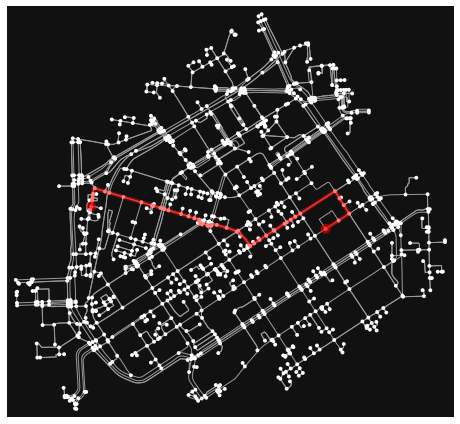

In [32]:
# Plot the shortest path
fig, ax = ox.plot_graph_route(graph_proj, route)

Nice! Now we have the shortest path between our origin and target locations.
Being able to analyze shortest paths between locations can be valuable information for many applications.
Here, we only analyzed the shortest paths based on distance but quite often it is more useful to find the
optimal routes between locations based on the travelled time. Here, for example we could calculate the time that it takes to cross each road segment by dividing the length of the road segment with the speed limit and calculate the optimal routes by taking into account the speed limits as well that might alter the result especially on longer trips than here.

## Saving shortest paths to disk

Quite often you need to save the route into a file for further analysis and visualization purposes, or at least have it as a GeoDataFrame object in Python.
Hence, let's continue still a bit and see how we can turn the route into a linestring and save the shortest path geometry and related attributes into a geopackage file.

- First we need to get the nodes that belong to the shortest path:


In [33]:
# Get the nodes along the shortest path
route_nodes = nodes_proj.loc[route]
route_nodes

,y,x,osmid,lon,lat,highway,ref,geometry
319719983,6.671816e+06,384706.296089,319719983,24.922273,60.166932,NaN,NaN,POINT (384706.296 6671815.989)
1382316822,6.671839e+06,384709.579017,1382316822,24.922319,60.167142,NaN,NaN,POINT (384709.579 6671839.311)
1382316829,6.671850e+06,384711.044607,1382316829,24.922339,60.167236,NaN,NaN,POINT (384711.045 6671849.707)
1382316852,6.671861e+06,384712.504583,1382316852,24.922359,60.167338,NaN,NaN,POINT (384712.505 6671860.984)
5464887863,6.671865e+06,384713.220293,5464887863,24.922370,60.167377,NaN,NaN,POINT (384713.220 6671865.374)
1382320461,6.671887e+06,384719.671826,1382320461,24.922473,60.167575,NaN,NaN,POINT (384719.672 6671887.215)
5154747161,6.671874e+06,384758.946564,5154747161,24.923188,60.167471,NaN,NaN,POINT (384758.947 6671874.411)
1378064352,6.671869e+06,384776.322613,1378064352,24.923504,60.167428,NaN,NaN,POINT (384776.323 6671869.117)
1372461709,6.671853e+06,384830.142058,1372461709,24.924482,60.167300,NaN,NaN,POINT (384830.142 6671853.149)
1372441203,6.671833e+06,384899.781649,1372441203,24.925748,60.167135,NaN,NaN,POINT (384899.782 6671832.539)


As we can see, now we have all the nodes that were part of the shortest path as a GeoDataFrame.

- Now we can create a LineString out of the Point geometries of the nodes:

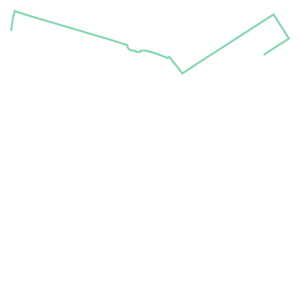

In [34]:
from shapely.geometry import LineString, Point

# Create a geometry for the shortest path
route_line = LineString(list(route_nodes.geometry.values))
route_line

Now we have the route as a LineString geometry. 

- Let's make a GeoDataFrame out of it having some useful information about our route such as a list of the osmids that are part of the route and the length of the route.

In [35]:
# Create a GeoDataFrame
route_geom = gpd.GeoDataFrame([[route_line]], geometry='geometry', crs=edges_proj.crs, columns=['geometry'])

# Add a list of osmids associated with the route
route_geom.loc[0, 'osmids'] = str(list(route_nodes['osmid'].values))

# Calculate the route length
route_geom['length_m'] = route_geom.length

route_geom.head()

,geometry,osmids,length_m
0,"LINESTRING (384706.296 6671815.989, 384709.579...","[319719983, 1382316822, 1382316829, 1382316852...",1342.967643


Now we have a GeoDataFrame that we can save to disk. Let's still confirm that everything is ok by plotting our route on top of our street network and some buildings, and plot also the origin and target points on top of our map.

- Get buildings:

In [36]:
tags = {'building': True}
buildings = ox.geometries_from_place(place_name, tags)

re-project buildings

In [37]:
buildings_proj = buildings.to_crs(CRS(edges_proj.crs))

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


- Let's now plot the route and the street network elements to verify that everything is as it should:

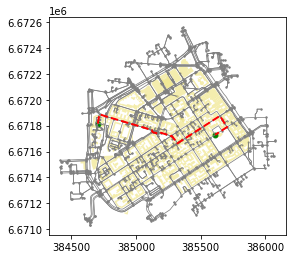

In [38]:
# Plot edges and nodes
ax = edges_proj.plot(linewidth=0.75, color='gray')
ax = nodes_proj.plot(ax=ax, markersize=2, color='gray')

# Add buildings
ax = buildings_proj.plot(ax=ax, facecolor='khaki', alpha=0.7)

# Add the route
ax = route_geom.plot(ax=ax, linewidth=2, linestyle='--', color='red')

# Add the origin and destination nodes of the route
ax = od_nodes.plot(ax=ax, markersize=24, color='green')

Great everything seems to be in order! As you can see, now we have a full control of all the elements of our map and we can use all the aesthetic properties that matplotlib provides to modify how our map will look like. Now we are almost ready to save our data into disk.


- As there are certain columns with such data values that Shapefile format does not support (such as `list` or `boolean`), we need to convert those into strings to be able to export the data to Shapefile:

In [39]:
# Columns with invalid values
invalid_cols = ['lanes', 'maxspeed', 'name', 'oneway', 'osmid']

# Iterate over invalid columns and convert them to string format
for col in invalid_cols:
    edges_proj[col] = edges_proj[col].astype(str)
    
print(edges_proj.dtypes)

osmid         object
oneway        object
lanes         object
name          object
highway       object
maxspeed      object
length       float64
geometry    geometry
access        object
bridge        object
junction      object
tunnel        object
service       object
u              int64
v              int64
key            int64
dtype: object


/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Now we can see that most of the attributes are of type `object` that quite often (such as ours here) refers to a string type of data.

- Now we are finally ready to parse the output filepaths and save the data into disk:

In [40]:
place_name_out = place_name.replace(' ', '_').replace(',','')
place_name_out

'Kamppi_Helsinki_Finland'

In [41]:
import os

# Parse the place name for the output file names (replace spaces with underscores and remove commas)
place_name_out = place_name.replace(' ', '_').replace(',','')

# Output directory
out_dir = "data"

# Create output fp for a geopackage
out_fp = os.path.join(out_dir, f"OSM_{place_name_out}.gpkg")

# Save files
edges_proj.to_file(out_fp, layer="streets", driver="GPKG")
route_geom.to_file(out_fp, layer="route", driver="GPKG")
nodes_proj.to_file(out_fp, layer="nodes", driver="GPKG")
od_nodes.to_file(out_fp, layer="route_OD", driver="GPKG")
buildings[['geometry', 'name', 'addr:street']].to_file(out_fp, layer="buildings", driver="GPKG")


ValueError: Invalid field type <class 'list'>

Great, now we have saved all the data that was used to produce the maps into a geopackage.